In [1]:
from __future__ import division,print_function
import pandas as pd
from utils import *
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# Contents
- A. Is ther a watch in the image?
- B. Image Quality Assessment
- C. Predict
- D. Output preview and Viz

# A. Is there a watch in the image?

## Using full imagenet weights
Among the imagenet synsets, there are few related to watchs, clocks:
- 409: 'analog clock'
- 530: 'digital clock'
- 531: 'digital watch'
- 826: 'stopwatch, stop watch'
- 892: 'wall clock'

### Which approach and How to validate?

One easy approach would be to use one of the imagenet pre-trained models with full weights in order to predict the 1000 classes of imagenet. Among these classes, there are 5 related to watches/clocks (see above). We can use the sum of probabilities of these classes as a confidence score. This score would then be between 0 and 1. The highest the score is, the higher the confidence will be. Based on this score, we can apply hard labeling as well, i.e. Boolean output for if there is a watch or not in the image. But how to pass to binary outputs? We will fine-tune the threshold allowing to predict boolean values. 

In order to validate in this approach, we can simply simply split manually the data into two different subfolders (watch or not). As the database is quiet small, not more than 635 images, it only takes few minutes. Once the predictions done on the entire set images, we can compare the predictions both probas and labels using specific metrics: roc_auc_curve, f1-score, accuracy. Of course the risk of introducing noise in the validation labels is high, as only one person constitutes the valdiation set (splitting the images into two classes vrey quickly), the judgement can differ from one person to another.

Here we only use ResNet50 for convenience. It's possible to use several other models for ensembling for further improvement.

### What to do with the feedback of users?

If we can have the feedback of users on small amount of data, we can further improve the model by making it learn on its errors. One thing would be to integrate their feedback in a training set in order to retrain and finetune the model. Hence, the model would get better over the time by integrating the annotations of users on the predictions. This implies a progressive calibration of the model over the time.

In [2]:
path = './data'
bs_1 = 1

##### Load the images splitting manually to 2 subfolders

In [3]:
# batches of images
_batches = get_batches(path, batch_size=bs_1, shuffle=False)

Found 635 images belonging to 2 classes.


##### Use a pre-trained model on imagenet dataset
Any of the models would do the job (VGG16, VGG19, ResNet, ...)

In [4]:
# model and imagenet probas
model = ResNet50(include_top=True, weights='imagenet')
probas_ = model.predict_generator(_batches, verbose=True)

635/635 [==============================] - 325s 512ms/step


##### How to build a confidence score?
We simply sum the probabilities of the 5 watch/clock imagenet synsets. 

In [5]:
# adapt probas to our case
clock_ids = [409, 530, 531, 826, 892]

probas_clocks = []
for idx, el in enumerate(probas_):
    probas_clocks.append(probas_[idx, clock_ids].sum()) # sum of clock children synsets probas

##### how to pass to binary labels?
We need to fine-tune the theshold for the labeling. We will base on the validation results.
It appears that the optimal threshold is around 0.01

In [6]:
# fine-tune the threshold for binary classification
for th in [0.01, 0.05, 0.10, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]:
    preds = [1 if el > th else 0 for el in probas_clocks] # binary output
    y_test = _batches.classes # validation labels
    
    roc_auc = roc_auc_score(y_test, probas_clocks)
    f1 = f1_score(y_test, preds)
    acc = accuracy_score(y_test, preds)

    print("th: {} :: ROC AUC S: {} -- F1 S: {} -- ACC: {}".format(th, roc_auc, f1, acc))

th: 0.01 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.829608938547486 -- ACC: 0.8078740157480315
th: 0.05 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.725552050473186 -- ACC: 0.7259842519685039
th: 0.1 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.6655629139072848 -- ACC: 0.6818897637795276
th: 0.2 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.5884413309982487 -- ACC: 0.6299212598425197
th: 0.25 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.5607142857142857 -- ACC: 0.6125984251968504
th: 0.3 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.5451263537906137 -- ACC: 0.6031496062992125
th: 0.35 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.5183823529411765 -- ACC: 0.5874015748031496
th: 0.4 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.49906890130353815 -- ACC: 0.5763779527559055
th: 0.45 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.4934579439252336 -- ACC: 0.573228346456693
th: 0.5 :: ROC AUC S: 0.9195794472490801 -- F1 S: 0.4763705103969754 -- ACC: 0.5637795275590551


In [7]:
# saving model weights
model.save_weights('./app/models/weights_resnet50.h5')

# B. Assessing the Quality of an image

We can be tempted by measuring the low-level degradations such as noise, blur, etc.. For example, we can use the variance of the Laplace Transform of the image to assess the level of blurness. Measuring low-level degradations would be the simplest approach.

However, it is also possible to use CNNs to automate the quality assessment of images. In the recent years, Deep Learning and CNNs have proven to be efficient in this application as well. Here below are some racent papers and approaches to test:
- Deep Neural Networks for No-Reference and Full-Reference Image Quality Assessment https://arxiv.org/abs/1612.01697v2
- NIMA: Neural Image Assessment https://arxiv.org/abs/1709.05424v1

We can use the MIMA pre-trained model (https://github.com/titu1994/neural-image-assessment). The model has been trained on the AVA dataset (Aesthetic Visual Analysis). (N.B. available in keras + tensorflow). It predicts the distribution of human opinion scores for the 'aesthetic quality'. Here we can take the mean of the scores to rank images based on their 'human like' aesthetic quality score. The lower the score is, the lower the aesthetic quality is likely to be.

PLEASE REFER TO UTILS FILES FOR RESPECTIVE FUNCTIONS

### How to validate the results?

Here as the results are continuous and stick to the annotations of the initial train set (i.e. AVA), it would be complicated to validate the continous values. 

- **ranking the images according to quality score**:

    We can rank randomly selected images and assess visually the coherence of the ranking. (See plot below). We can see that the lowest quality images are either strongly blurred or very small images.

    It constitutes a naive and not "proper" approach to validate the model.


- **trying to reproduce the annotation system of the initial experiment, Using user feedbacks**:

    **We can take fully benefit of user feedback**

    If annotators can annotate the images, based on the initial experiment rules, we can use their feedbacks as ground-truth and validate the model. Here the IQA model tries to predict the distribution of scores, and we're outputing the mean score.

    We can ask 10 annotators to score the quality based on their human perception and original rules, and compute the mean score per image as well. Hence, comparing the two mean would be a solution. We can even directly compare the distribution of scores. 

    This solution is possible as the initial experiment is based on human socring as well.


# C. Predict
Predict image quality, label (i.e. watch or not) and the confidence score.

In [8]:
path_to_images = './images_mix'

# LOADING IMAGES
print('Loading images')
test_images, test_index =  load_images(path_to_images)
print('Found', len(test_images), 'images to predict on')

# LOADING MODELS
print('Loading models')
iqa = IQA('./app/models/inception_resnet_weights.h5')
tfl = ResNet50(include_top=True, weights='./app/models/weights_resnet50.h5')

# PREDICT
print('Predicting probas & labels: is there a watch ?')
th = 0.01
_probas = tfl.predict(test_images, batch_size=1, verbose=True)
probas_ = synsets2clocks(_probas)
labels_ = [el > th for el in probas_]

print('Predicting Image Quality scores')
#preprocessing adapted to inceptionresnet_v2
test_images = 2*(test_images/255.0)-1.0

# mean scores
scores = iqa.predict(test_images, batch_size=1, verbose=1)
scores_ = [mean_score(el) for el in scores]

out_dict = dict()
for idx, el in enumerate(test_index):
    out_dict[el] = dict()
    out_dict[el]['quality_score'] = scores_[idx]
    out_dict[el]['watch_pred'] = (labels_[idx], probas_[idx])

Loading images
Found 635 images to predict on
Loading models
Predicting probas & labels: is there a watch ?
635/635 [==============================] - 347s 546ms/step
Predicting Image Quality scores
635/635 [==============================] - 407s 641ms/step


## D. Output Preview and Viz

In [9]:
df = pd.DataFrame.from_dict(out_dict, orient='index').sort_values(by='quality_score',ascending=False)
df.head()

,quality_score,watch_pred
./images_mix\3525525541.jpg,5.932497,"(True, 0.46488)"
./images_mix\68428_3.jpg,5.630195,"(False, 0.000169092)"
./images_mix\63159_5.jpg,5.519511,"(True, 0.0401716)"
./images_mix\3500530527.jpg,5.497072,"(True, 0.991445)"
./images_mix\3258070264.jpg,5.485295,"(True, 0.154169)"


#### Top 20 and last 20, based on image quality
The ranking looks coherent at least for the extreme cases.

In [10]:
def plot_demo(data):
    """ Plotting Demos, with respective predictions"""
    fig, ax = plt.subplots(ncols= 5, nrows=4, sharex=True, sharey=True, figsize=(20,15))
    ax = ax.ravel()
    for idx, im_p in enumerate(data.index):
        im = imread(im_p)
        ax[idx].imshow(im)
        ax[idx].set_title('quality: {:.2f} - watch: {} | {:.2f}'.format(data.iloc[idx]['quality_score'],
                                                 data.iloc[idx]['watch_pred'][0],
                                                 data.iloc[idx]['watch_pred'][1]))
        ax[idx].axis('off')
    plt.tight_layout()

##### Top 20, based on quality

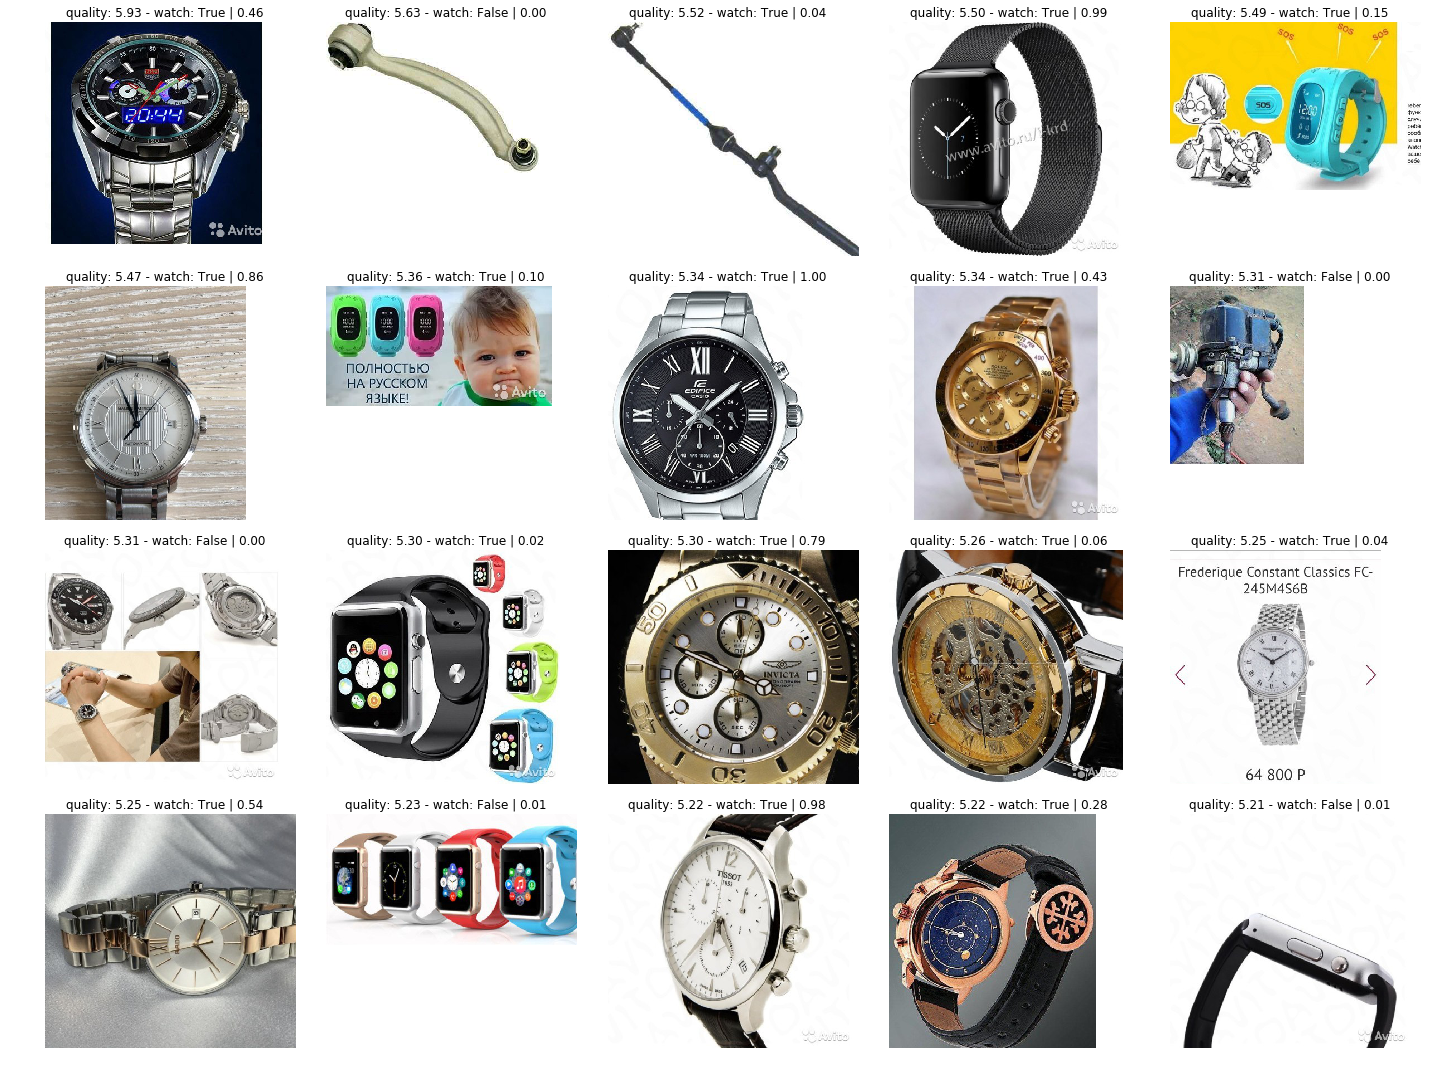

In [11]:
# top 20 
plot_demo(df.head(20))

##### Last 20, based on quality

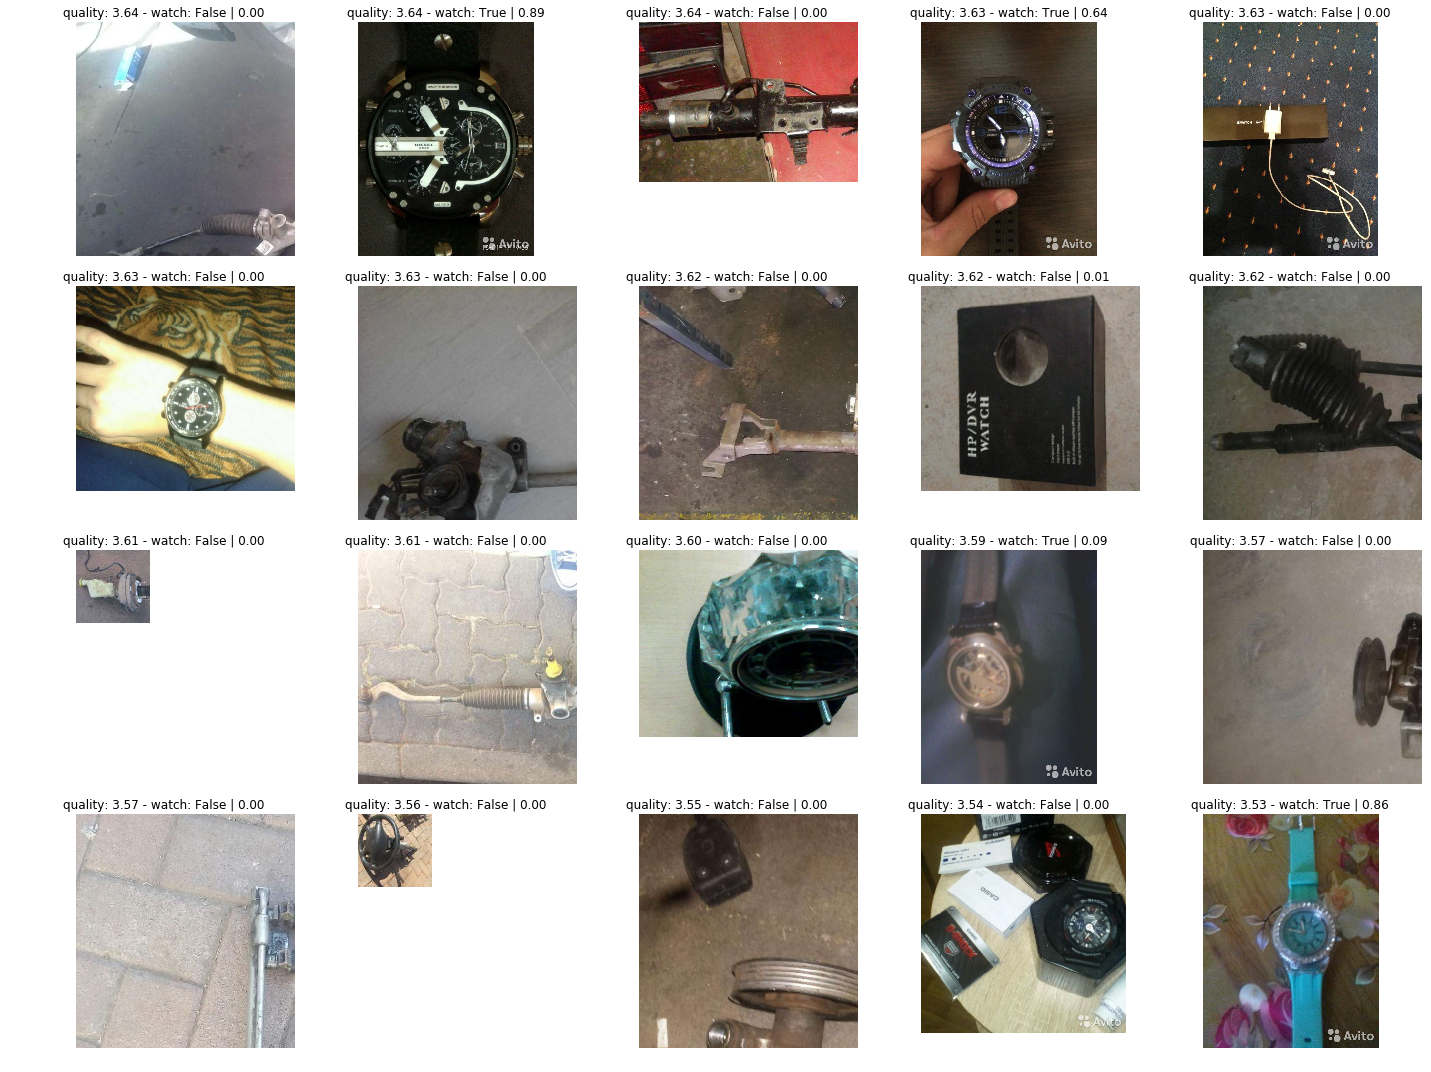

In [12]:
# last 20
plot_demo(df.tail(20))